# Action Priors in 1D

## Imports

In [16]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
import tensorflow_probability as tfp
tfd = tfp.distributions
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
import datetime

from IPython.core.debugger import set_trace

In [17]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
# load env
from src.envs.LinearEnv import LinearEnv


# cell magic for reloading imported modules
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Environment
- State: 
    - $s \in \mathbb{R}^{(1)}$
- Simulates a frog jumping over pools of lava in 1D.
- Should use 1D arrays for states and actions, etc.

In [18]:
%autoreload 2
# instantiate env
env = LinearEnv(8,randomize=False, visualize=True)

## Random Agent

In [19]:
# random agent
def random_agent(obs):
    return {"Action":np.random.uniform(-0.3,0.3,size=(1,))}

In [20]:
# run a single episode for an agent in the environment and return the rollout

def get_episode_trajectory(env, agent, max_steps=1000):
    observation_list = []
    reward_list = []
    action_list = []
    value_list = []


    done = False
    obs = env.reset()
    for i in range(max_steps):
        observation_list.append(obs.copy())
        out = agent(obs)
        
        assert ("Action" in out), "The key 'Action' was missing from the agents output."
        action = out["Action"]
        obs, rew, done, _, = env.step(action)
        reward_list.append(rew)
        action_list.append(action.copy())
        if "Value" in out:
            value_list.append(out["Value"])
            
        if done:
            break
        
    ret = {
        "Observations": observation_list, 
        "Actions": action_list, 
        "Rewards": np.array(reward_list, dtype=np.float32)
    }
    if len(value_list) > 0:
        ret["Values"] = value_list
        
    return ret

In [21]:
def reward_to_go(rewards):
    return np.flip(np.cumsum(np.flip(rewards)))
def returns(rewards):
    return np.sum(rewards)

$$
\large \nabla_{\theta}J(\theta) \approx \frac{1}{N}\sum \limits_{i = 1}^{N}\left( \nabla_{\theta}\sum \limits_{t = 1}^{T} log\pi_{\theta}(s_{i,t}\mid a_{i,t})\right)\left( \sum \limits_{t = 1}^{T}r(s_{i,t},a_{i,t}) - b\right)
$$

In [22]:
def loss_pg(log_probs, returns):
    
    log_probs = tf.reduce_sum(log_probs, axis=0)
    
    if np.ndim(returns) > 1:
        returns = np.sum(returns, axis = 1)
    else:
        returns = np.sum(returns)
    
    return -tf.reduce_mean(returns * log_probs)

## Training Loop

In [23]:
def train_policy_grad(env, agent, num_epochs=300):
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    train_log_dir = 'logs/' + current_time + '/train'
    # test_log_dir = 'logs/gradient_tape/' + current_time + '/test'
    train_summary_writer = tf.summary.create_file_writer(train_log_dir)
       
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    
    log_reward = 0
    log_reward_list = []
    logging_period = 1
    num_trajectories = 5
    
    for epoch in range(num_epochs):
        
        obs_list = []
        rew_list = []
        actions_list = []
        returns_list = []
        log_probs_list = []
        
        epoch_gradients = []
        for i in range(num_trajectories):
            with tf.GradientTape(persistent=True) as tape:
                traj = get_episode_trajectory(env, agent) # trajectories may vary in length
                
                # lists no longer needed
                obs_list.append(np.stack(traj["Observations"]))
                actions_list.append(traj["Actions"])
                # compute 'reward-to-go'
                # rew_2_go = reward_to_go(rew)
                returns_list.append(np.sum(traj["Rewards"]))
                
                log_probs = agent.action_dist.log_prob(traj["Actions"])

                log_prob_sum = tf.reduce_sum(log_probs)
                
            # compute baseline
            baseline = 0

            # compute gradients + update weights
            traj_gradients = []
            for layer in agent_mlp_tf.trainable_variables:
                
                layer_grad_log_sum = -1*tape.gradient(log_prob_sum, layer)*(np.sum(reward_to_go(traj["Rewards"])) - baseline)

                traj_gradients.append(layer_grad_log_sum)
            epoch_gradients.append(traj_gradients)
        
        gradients = []
        for i in range(len(agent.trainable_variables)):
            l_grads = []
            for row, traj_grads in enumerate(epoch_gradients):
                l_grads.append(traj_grads[i])
                       
            gradients.append(tf.reduce_mean(l_grads,axis=0))
        
        
        optimizer.apply_gradients(zip(gradients, agent.trainable_variables))
        
        
        with train_summary_writer.as_default():
            tf.summary.scalar('Return', np.mean(returns_list), step=epoch)
#             tf.summary.histogram("Action", tf.reduce_mean(out["Action"]) , step=epoch)
            tf.summary.histogram("LogProbability sum", tf.reduce_mean(log_prob_sum) , step=epoch)
#             tf.summary.histogram("Sigma", tf.reduce_mean(out["Scale"]) , step=epoch)
#             tf.summary.histogram("Mu", tf.reduce_mean(out["Loc"]) , step=epoch)
            
            for i,g in enumerate(gradients):
                tf.summary.histogram("gradient_"+str(i),tf.reduce_mean(g), step=epoch)

        
        # log the reward
        log_reward += np.sum(np.mean(returns_list))
        if (epoch % logging_period) == 0:
            template = 'Training Epoch {}, Averaged Return: {}'
            print(template.format(epoch, log_reward / logging_period))
            log_reward_list.append(log_reward / logging_period)
            log_reward = 0
       
    return (range(0, num_epochs, logging_period), log_reward_list)

Training Epoch 0, Averaged Return: -878.7130126953125
Training Epoch 1, Averaged Return: -722.3113403320312
Training Epoch 2, Averaged Return: -1320.391845703125
Training Epoch 3, Averaged Return: -863.30810546875
Training Epoch 4, Averaged Return: -1096.59375
Training Epoch 5, Averaged Return: -1108.090576171875
Training Epoch 6, Averaged Return: -1206.275146484375
Training Epoch 7, Averaged Return: -780.2210693359375
Training Epoch 8, Averaged Return: -1045.129150390625
Training Epoch 9, Averaged Return: -1270.693359375
Training Epoch 10, Averaged Return: -1034.6856689453125
Training Epoch 11, Averaged Return: -1016.7145385742188
Training Epoch 12, Averaged Return: -1158.095458984375
Training Epoch 13, Averaged Return: -980.1905517578125
Training Epoch 14, Averaged Return: -1180.0986328125
Training Epoch 15, Averaged Return: -1165.709716796875
Training Epoch 16, Averaged Return: -918.5943603515625
Training Epoch 17, Averaged Return: -1291.097412109375
Training Epoch 18, Averaged Retu

Training Epoch 149, Averaged Return: -286.5391540527344
Training Epoch 150, Averaged Return: -299.15887451171875
Training Epoch 151, Averaged Return: -248.882568359375
Training Epoch 152, Averaged Return: -218.3595733642578
Training Epoch 153, Averaged Return: -295.5204162597656
Training Epoch 154, Averaged Return: -256.13677978515625
Training Epoch 155, Averaged Return: -214.1280975341797
Training Epoch 156, Averaged Return: -157.69813537597656
Training Epoch 157, Averaged Return: -252.21640014648438
Training Epoch 158, Averaged Return: -197.73336791992188
Training Epoch 159, Averaged Return: -233.6224365234375
Training Epoch 160, Averaged Return: -210.61474609375
Training Epoch 161, Averaged Return: -154.79052734375
Training Epoch 162, Averaged Return: -151.25369262695312
Training Epoch 163, Averaged Return: -164.0354766845703
Training Epoch 164, Averaged Return: -317.26055908203125
Training Epoch 165, Averaged Return: -256.407470703125
Training Epoch 166, Averaged Return: -312.17517

Training Epoch 295, Averaged Return: -218.15249633789062
Training Epoch 296, Averaged Return: -174.25323486328125
Training Epoch 297, Averaged Return: -193.88381958007812
Training Epoch 298, Averaged Return: -459.2433166503906
Training Epoch 299, Averaged Return: -235.19027709960938


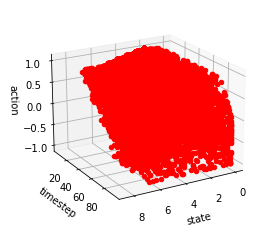

In [24]:
# load agent
from src.agents.AgentMLPTF import AgentMLPTF

agent_mlp_tf = AgentMLPTF()
(episodes, rewards) = train_policy_grad(env, agent_mlp_tf)

In [25]:
s = env.reset()
print(np.array(s.ndim))
eps = 300
states = []
rewards_1 = []
for i in range(eps):
    traj = get_episode_trajectory(env, random_agent)
    rewards_1.append(np.sum(traj["Rewards"]))
    

1


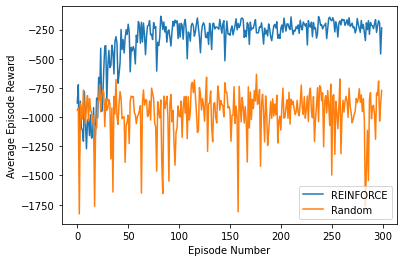

In [26]:
plt.plot(episodes, rewards, label="REINFORCE")
plt.plot(episodes, rewards_1, label="Random")
plt.xlabel('Episode Number')
plt.ylabel('Average Episode Reward')
plt.legend()
plt.show()

1


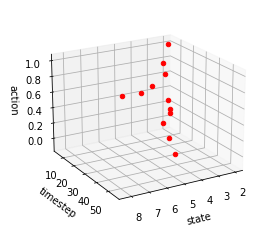

In [36]:
%autoreload 2
# instantiate env
env = LinearEnv(8,randomize=False, visualize=True)

s = env.reset()
print(np.array(s.ndim))
eps = 100
states = []

for i in range(eps):
    
    a = agent_mlp_tf(s)["Action"]
    s,r,done,_ = env.step(a)
    states.append(np.array([s,a]))
    if done:
        break

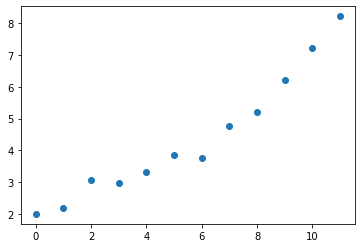

In [37]:
arr = np.array(states)
plt.scatter(list(range(arr.shape[0])),arr[:,0])

(array([2., 2., 2., 1., 0., 0., 2., 1., 0., 2.]),
 array([-0.09192463,  0.1485388 ,  0.38900222,  0.62946565,  0.86992907,
         1.1103925 ,  1.35085592,  1.59131935,  1.83178277,  2.0722462 ,
         2.31270963]),
 <BarContainer object of 10 artists>)

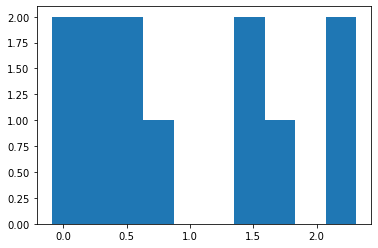

In [38]:
plt.hist(arr[:,1])

In [39]:
arr[:,0]

array([[2.        ],
       [2.18879725],
       [3.05482218],
       [2.98217352],
       [3.30487556],
       [3.858996  ],
       [3.76707137],
       [4.76707137],
       [5.22296011],
       [6.22296011],
       [7.22296011],
       [8.22296011]])